In [21]:
import os
import random
import pandas as pd
import pyiqa
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
image_folder = "koniq10k_512x384"
indicators_csv = "koniq10k_indicators.csv"
scores_csv = "koniq10k_scores_and_distributions.csv"

indicators_df = pd.read_csv(indicators_csv)
scores_df = pd.read_csv(scores_csv)

brisque_metric = pyiqa.create_metric("brisque")
niqe_metric = pyiqa.create_metric("niqe")
piqe_metric = pyiqa.create_metric("piqe")

In [23]:
results = {"image": [], "brisque": [], "niqe": [], "piqe": [], "actual_score": []}

all_images = [
    img
    for img in os.listdir(image_folder)
    if img.lower().endswith((".png", ".jpg", ".jpeg"))
]
random_images = random.sample(all_images, min(100, len(all_images)))

for image_name in tqdm(random_images):
    image_path = os.path.join(image_folder, image_name)

    try:
        brisque_score = brisque_metric(image_path).item()
        niqe_score = niqe_metric(image_path).item()
        piqe_score = piqe_metric(image_path).item()

        # Invert and normalize scores to align with MOS
        brisque_score = 1 + 4 * (1 - (brisque_score - 0) / (100 - 0))  # BRISQUE range ~0-100
        niqe_score = 1 + 4 * (1 - (niqe_score - 0) / (15 - 0))  # NIQE range ~0-15
        piqe_score = 1 + 4 * (1 - (piqe_score - 0) / (100 - 0))  # PIQE range ~0-100
    except Exception as e:
        print(f"Error processing {image_name}: {e}")
        continue

    actual_score_row = scores_df[scores_df["image_name"] == image_name]
    actual_score = (
        actual_score_row["MOS"].values[0] if not actual_score_row.empty else None
    )

    results["image"].append(image_name)
    results["brisque"].append(brisque_score)
    results["niqe"].append(niqe_score)
    results["piqe"].append(piqe_score)
    results["actual_score"].append(actual_score)

100%|██████████| 100/100 [00:09<00:00, 10.63it/s]


Quality Assessment Results:
             image   brisque      niqe      piqe  actual_score
0   9722821291.jpg  3.551145  3.899363  3.636194      2.285714
1  11163249414.jpg  3.596614  3.890842  3.520002      3.412371
2   3812031514.jpg  2.898000  3.200994  3.236805      3.556522
3   8416061748.jpg  4.842493  4.304969  3.929100      3.598131
4   6895365088.jpg  4.578040  4.139463  3.973558      3.575472


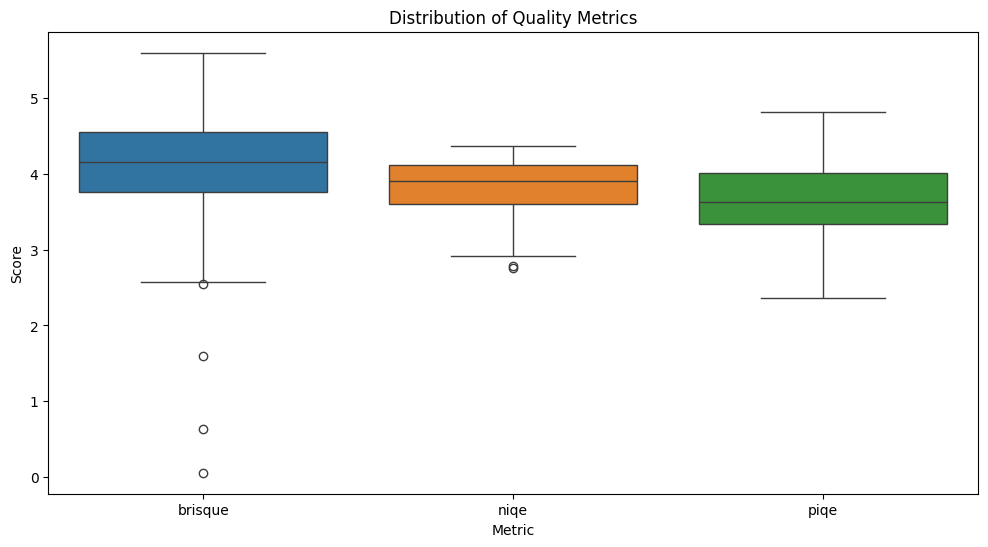

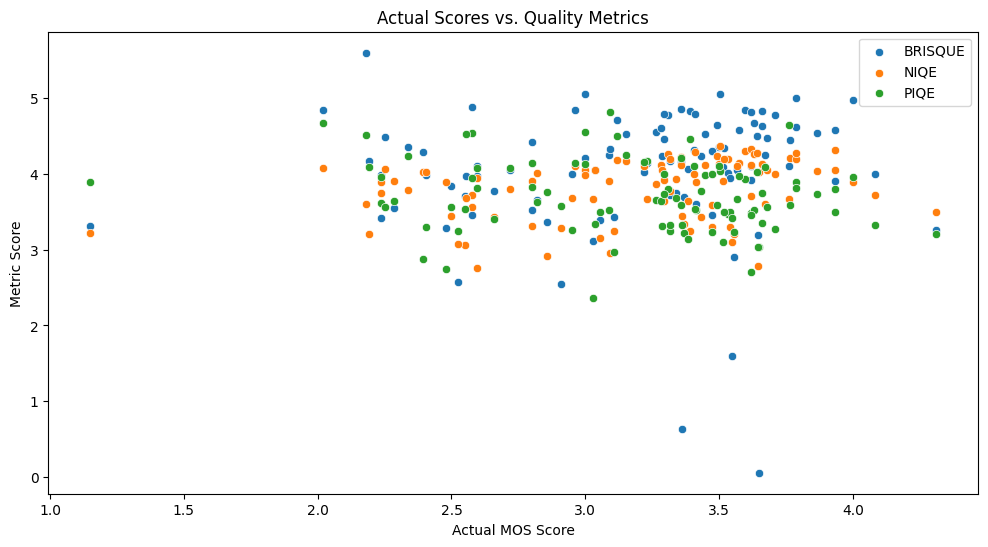

In [24]:
# Convert results to a DataFrame and visualize
results_df = pd.DataFrame(results)

print("Quality Assessment Results:")
print(results_df.head())

plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df[["brisque", "niqe", "piqe"]])
plt.title("Distribution of Quality Metrics")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x=results_df["actual_score"], y=results_df["brisque"], label="BRISQUE")
sns.scatterplot(x=results_df["actual_score"], y=results_df["niqe"], label="NIQE")
sns.scatterplot(x=results_df["actual_score"], y=results_df["piqe"], label="PIQE")
plt.title("Actual Scores vs. Quality Metrics")
plt.xlabel("Actual MOS Score")
plt.ylabel("Metric Score")
plt.legend()
plt.show()